✅ 실험 1: Horizon을 1000으로 늘린 epsilon-Greedy 고정 실험
- ε 값을 고정(0.1 ~ 0.5)

- horizon = 1000

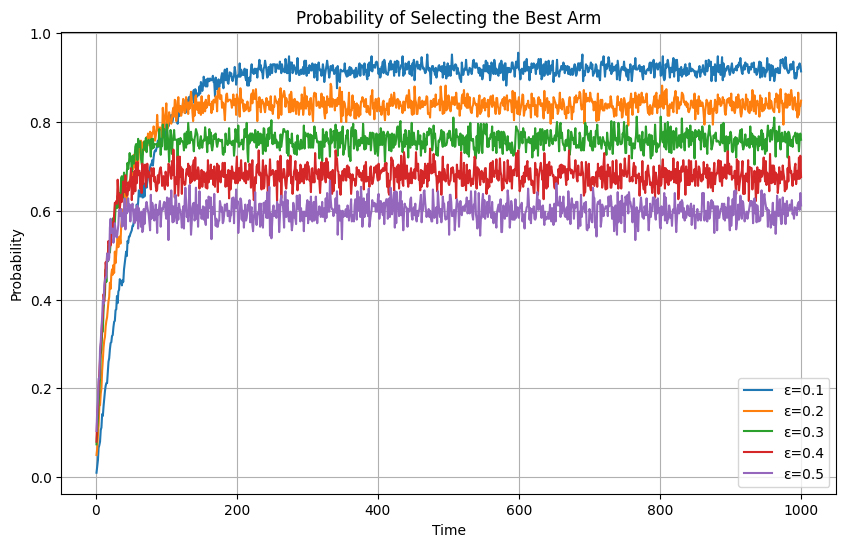

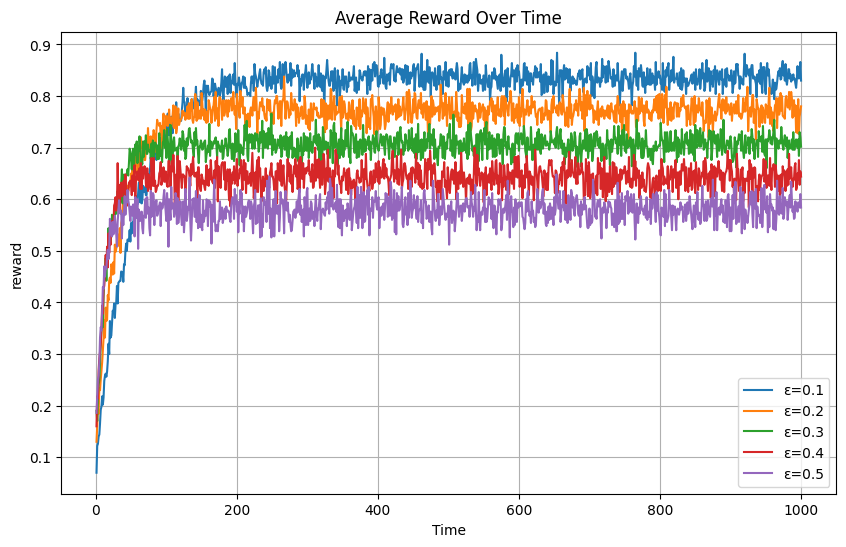

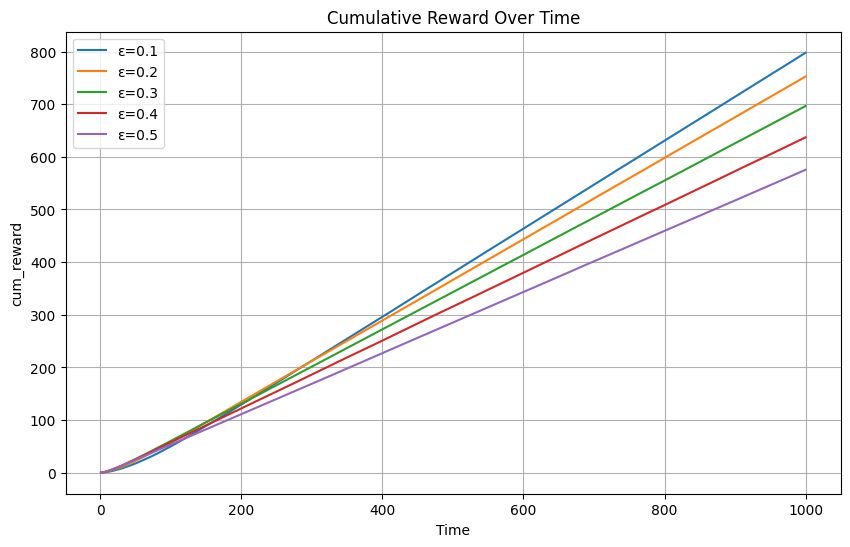

In [ ]:
import random
import pandas as pd
import matplotlib.pyplot as plt

# 1. Bernoulli Arm
class BernoulliArm():
    def __init__(self, p):
        self.p = p
    def draw(self):
        return 1.0 if random.random() < self.p else 0.0

# 2. Epsilon-Greedy (고정)
class EpsilonGreedy():
    def __init__(self, epsilon):
        self.epsilon = epsilon
    def initialize(self, n_arms):
        self.counts = [0] * n_arms
        self.values = [0.0] * n_arms
    def select_arm(self):
        if random.random() > self.epsilon:
            return self.values.index(max(self.values))
        return random.randrange(len(self.values))
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        self.values[chosen_arm] = ((n - 1)/n)*value + (1/n)*reward

# 3. Test Framework
def test_algorithm(algo, arms, num_sims, horizon, label):
    result = {"experiment": [], "sim": [], "time": [], "arm": [], "reward": [], "cum_reward": []}
    for sim in range(num_sims):
        algo.initialize(len(arms))
        total = 0.0
        for t in range(1, horizon + 1):
            arm = algo.select_arm()
            reward = arms[arm].draw()
            algo.update(arm, reward)
            total += reward
            result["experiment"].append(label)
            result["sim"].append(sim)
            result["time"].append(t)
            result["arm"].append(arm)
            result["reward"].append(reward)
            result["cum_reward"].append(total)
    return pd.DataFrame(result)

# 실험 환경
random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
random.shuffle(means)
arms = [BernoulliArm(p) for p in means]
best_arm = means.index(max(means))
num_sims, horizon = 500, 1000

# 실험 실행
df_list = []
for eps in [0.1, 0.2, 0.3, 0.4, 0.5]:
    algo = EpsilonGreedy(eps)
    df_list.append(test_algorithm(algo, arms, num_sims, horizon, f"ε={eps}"))
df_all = pd.concat(df_list)

# 시각화
def plot_metric(df, metric, title):
    plt.figure(figsize=(10, 6))
    for label in df["experiment"].unique():
        subset = df[df["experiment"] == label]
        y = subset.groupby("time")[metric].mean()
        plt.plot(y.index, y.values, label=label)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel(metric)
    plt.legend()
    plt.grid()
    plt.show()

def plot_best_arm_prob(df, best_arm):
    plt.figure(figsize=(10, 6))
    for label in df["experiment"].unique():
        subset = df[df["experiment"] == label]
        prob = subset.groupby("time")["arm"].apply(lambda x: sum(x == best_arm) / len(x))
        plt.plot(prob.index, prob.values, label=label)
    plt.title("Probability of Selecting the Best Arm")
    plt.xlabel("Time")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid()
    plt.show()

# 그래프 출력
plot_best_arm_prob(df_all, best_arm)
plot_metric(df_all, "reward", "Average Reward Over Time")
plot_metric(df_all, "cum_reward", "Cumulative Reward Over Time")


✅ 실험 2: Time-Varying Epsilon 실험 (증가 / 감소)
- ε 값을 시간에 따라 스케줄링 (250/500/1000 기준)

- 두 실험:

  - 증가: ε = 0.1 → 0.3 → 0.5

  - 감소: ε = 0.5 → 0.3 → 0.1

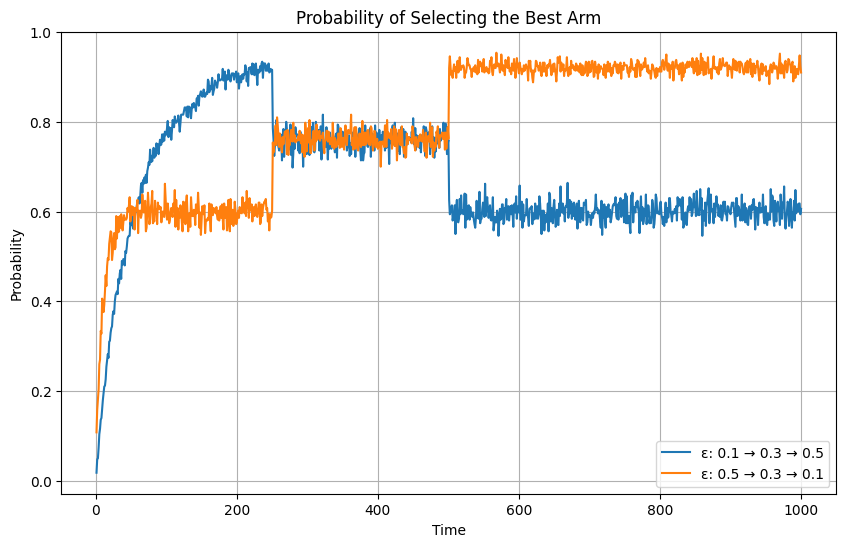

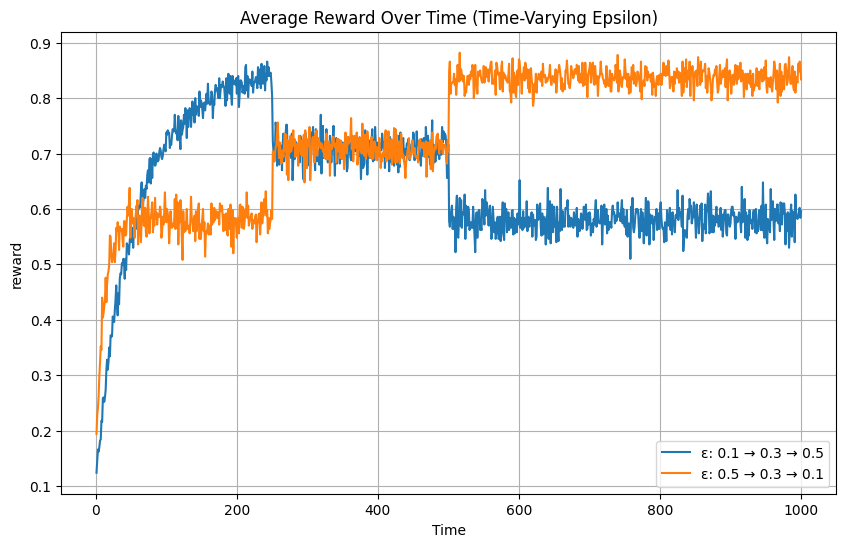

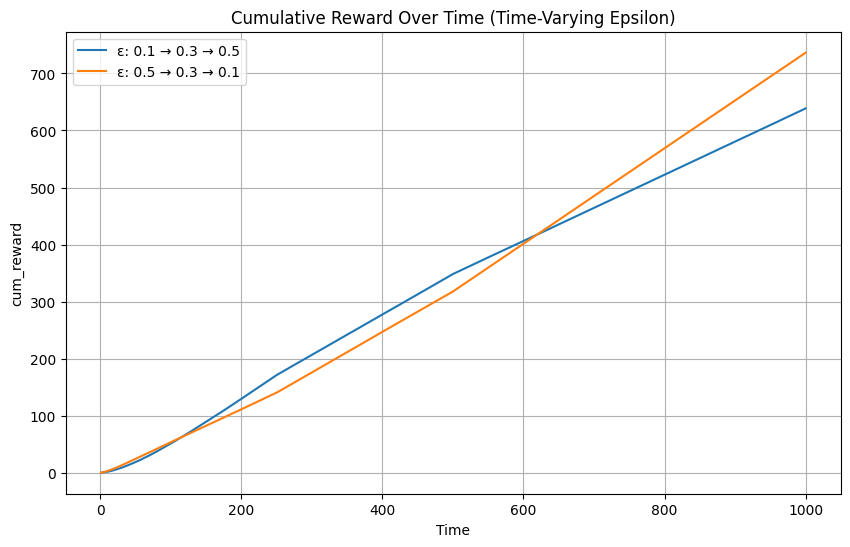

In [ ]:
# 1. Time-Varying Epsilon
class EpsilonGreedySchedule():
    def __init__(self, schedule):
        self.schedule = schedule
        self.t = 0
        self.counts = []
        self.values = []
        self.epsilon = list(schedule.values())[0]
    def initialize(self, n_arms):
        self.counts = [0 for _ in range(n_arms)]
        self.values = [0.0 for _ in range(n_arms)]
        self.t = 0
    def select_arm(self):
        self.t += 1
        for bound in sorted(self.schedule.keys()):
            if self.t <= bound:
                self.epsilon = self.schedule[bound]
                break
        if random.random() > self.epsilon:
            return self.values.index(max(self.values))
        else:
            return random.randrange(len(self.values))
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        self.values[chosen_arm] = ((n - 1) / float(n)) * value + (1 / float(n)) * reward

# 2. 실행
df1 = test_algorithm(EpsilonGreedySchedule({250: 0.1, 500: 0.3, 1000: 0.5}), arms, num_sims, horizon, "ε: 0.1 → 0.3 → 0.5")
df2 = test_algorithm(EpsilonGreedySchedule({250: 0.5, 500: 0.3, 1000: 0.1}), arms, num_sims, horizon, "ε: 0.5 → 0.3 → 0.1")
df_sched = pd.concat([df1, df2])

# 3. 시각화
plot_best_arm_prob(df_sched, best_arm)
plot_metric(df_sched, "reward", "Average Reward Over Time (Time-Varying Epsilon)")
plot_metric(df_sched, "cum_reward", "Cumulative Reward Over Time (Time-Varying Epsilon)")
